In [1]:
import pandas as pd
import math
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import networkx as nx
import community as community_louvain  # Install python-louvain package
from Seb_Folder.Louvain import NewsData, calculate_modularity
from networkx.algorithms.community import louvain_communities, modularity
from random import randint, seed
import ast

np.random.seed(42)
seed(42)

Firstly, we load the data and filter it accordingly.

In [ ]:
stock_data = "Stock_prices_2021_to_2024.csv"
reddit_data = "Reddit_2021_to_2024.csv"
news_data = "cleaned_combined_news_with_bodies_with_sentiment.csv"
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "NVIDIA": "NVDA",
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Alphabet": "GOOGL",
    "Meta": "META"
}

# Load the stock data
stock_df = pd.read_csv(stock_data)
# Load the reddit data
reddit_df = pd.read_csv(reddit_data)
# Load the news data
news_df = pd.read_csv(news_data)

# Add the title and body columns together
#reddit_df['body'] = reddit_df['title'] + ' ' + reddit_df['body']
news_df['body'] = news_df['title'] + ' ' + news_df['body']
print("Added the df's together")

# Drop rows with NA values
#reddit_df = reddit_df.dropna(subset=['body', 'title'])
news_df = news_df.dropna(subset=['body', 'title'])

reddit = NewsData(news_df)
print("Created the NewsData object")

reddit.df['stock'] = reddit.df['stock'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 1: Build LSH and find near-duplicates
print("Size before merge: ", len(reddit.df))
reddit.build_lsh(threshold=0.97)  # High threshold to detect near-duplicates
print("Built the LSH")
duplicate_groups = reddit.find_duplicates()
print("Found duplicates")
    
# Step 2: Merge near-duplicates
reddit.merge_duplicates(duplicate_groups)
print("Merged duplicates, size: ", len(reddit.df))

reddit.delete_lsh()


Added the df's together
Created the NewsData object
Size before merge:  32242


Building LSH index: 100%|██████████| 32242/32242 [02:04<00:00, 258.10it/s]


Built the LSH
Found duplicates
Merged duplicates, size:  31501


In [4]:
from tqdm import tqdm

# Create the graph
G = nx.Graph()
num_docs = reddit.df.shape[0]
total_comparisons = num_docs * (num_docs - 1) // 2

reddit.build_lsh(threshold=0.42, num_perm=2048)  # Lower threshold for general similarity

# Add edges to the graph based on similarity scores
for i, j in tqdm(reddit.compute_similarity_lsh(), total=total_comparisons, desc="Building Graph"):
    G.add_edge(int(i), int(j))


Building Graph:   0%|          | 344042/496140750 [00:20<8:21:11, 16487.24it/s] 


In [5]:
# Perform Louvain community detection
partition = louvain_communities(G, resolution=1)

# Print the community detection results
print("\nLouvain Community Detection Result:")
print(partition)
    
print("\nModularity:", modularity(G, partition))


Louvain Community Detection Result:
[{492, 7}, {9, 10}, {5123, 8197, 1292, 13, 5900, 7183, 3103, 6178, 551, 807, 2345, 3388, 2879, 3647, 10561, 324, 3405, 1358, 2637, 5203, 4950, 4184, 3674, 13403, 1115, 5980, 15968, 1635, 3683, 22629, 19306, 5743, 3443, 884, 3962, 2435, 643, 1419, 5518, 9361, 4502, 4765, 10143, 12960, 938, 3759, 14513, 6066, 2233, 445, 4029, 961, 1218, 4804, 3528, 1485, 3792, 4309, 15573, 15071, 3553, 2017, 1765, 12261, 5867, 12524, 12013, 6130, 6131, 245, 3833}, {546, 14}, {457, 890, 21}, {1280, 5002, 2892, 976, 3217, 978, 977, 980, 25, 1243, 931, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 1388, 3951, 1385, 1387, 1386, 1209}, {27, 893}, {28, 20047}, {22593, 47}, {49, 50}, {52, 1733}, {54, 867, 91, 27926}, {72, 82}, {1728, 98}, {13897, 99}, {100, 17186, 18955, 18532}, {128, 168}, {129, 3149}, {529, 834, 1332, 824, 137, 764}, {144, 143}, {146, 18978}, {165, 534}, {201, 202}, {207, 775}, {226, 1755, 3781}, {333, 238}, {489, 242, 535}, {257, 5537}, {259, 621}, {277

In [23]:
reddit.df['stock']

0        []
1        []
2        []
3        []
4        []
         ..
31496    []
31497    []
31498    []
31499    []
31500    []
Name: stock, Length: 31501, dtype: object

In [ ]:
# Add the community to the dataframe

for community in partition:
    print("Community: ", community)
    for node in community:
        reddit.df.at[node, 'community'] = community


Community:  {492, 7}
Node:  492


ValueError: Must have equal len keys and value when setting with an iterable

In [13]:
print("Indices in community:", list(community))
print("Indices in DataFrame:", reddit.df.index)

Indices in community: [31440, 31464]
Indices in DataFrame: RangeIndex(start=0, stop=31501, step=1)


In [11]:
reddit.df.head(5)

stock                 timestamp  \
0    [] 2021-01-02 13:28:07+00:00   
1    [] 2021-01-02 16:25:30+00:00   
2    [] 2021-01-03 13:12:08+00:00   
3    [] 2021-01-03 15:45:16+00:00   
4    [] 2021-01-03 16:06:22+00:00   

                                               title  \
0           Will Shopify Stock Reach $2,000 By 2022?   
1  Benzinga's Final Bulls And Bears Of The Year: ...   
2  Nio's Record Run Continues as Deliveries Spike...   
3  Nio Launches 'NIO Certified' Used Car Service ...   
4  Will Tesla, Apple and Amazon Help The QQQ ETF ...   

                                                body        Source  \
0  Will Shopify Stock Reach $2,000 By 2022? every...  benzinga.com   
1  Benzinga's Final Bulls And Bears Of The Year: ...  benzinga.com   
2  Nio's Record Run Continues as Deliveries Spike...  benzinga.com   
3  Nio Launches 'NIO Certified' Used Car Service ...  benzinga.com   
4  Will Tesla, Apple and Amazon Help The QQQ ETF ...  benzinga.com   

  sentiment_label  sentiment_score  positive_score  negative_score  \
0        negative        -0.334032        0.166189        0.500221   
1         neutral         0.006354        0.131538        0.125184   
2        negative        -0.122117        0.003327        0.125444   
3        negative        -0.682603        0.000356        0.682959   
4        negative        -0.334210        0.166196        0.500406   

   neutral_score                                            cleaned  community  
0       0.333590  shopify reach 2000 2022 every week benzinga co...        NaN  
1       0.743278  benzingas final bulls bears year alibaba apple...        NaN  
2       0.871229  nios record run continues deliveries spike 121...        NaN  
3       0.316685  nio launches nio certified used car china amid...        NaN  
4       0.333398  tesla apple amazon qqq etf reach 400 2022 ever...        NaN

In [6]:
# Remove communities consisting of under 4 nodes
print("\nNumber of Communities:", len(partition))

# Make a list of distinct colors for the communities
colors = ["#"+''.join([randint(0, 255).to_bytes(1, 'big').hex() for _ in range(3)]) for _ in range(len(partition))]



Number of Communities: 1618


In [14]:
import netwulf as nw
import matplotlib.pyplot as plt

# Assign nodes to their corresponding communities
node_to_community = {}
for community_index, community in enumerate(partition):
    for node in community:
        node_to_community[node] = community_index

# Add the community data to each node as an attribute
for node in G.nodes():
    G.nodes[node]['group'] = node_to_community[node]

# Calculate community sizes
community_sizes = {i: len(community) for i, community in enumerate(partition)}

# Sort communities by size and retain the top 75% by size
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
cumulative_size = sum(size for _, size in sorted_communities)
threshold = 0.75 * cumulative_size  # Top 75% of total node coverage

# Find the largest communities that make up the top 75% of the size
selected_communities = set()
current_size = 0
for community_index, size in sorted_communities:
    if current_size + size > threshold:
        break
    selected_communities.add(community_index)
    current_size += size

# Copy graph and remove nodes from excluded communities
graph_to_plot = G.copy()
for node in list(graph_to_plot.nodes()):  # Convert to list to avoid runtime errors during iteration
    if node_to_community[node] not in selected_communities:
        graph_to_plot.remove_node(node)

print("Number of nodes:", graph_to_plot.number_of_nodes())

# Visualize the updated graph
nw.visualize(graph_to_plot, config={'zoom': 0.1, 'linkAlpha': 0.1, 'collisions': False})

Number of nodes: 13275


(None, None)

In [15]:
aggregate_graph = nx.Graph()

for node in graph_to_plot.nodes(data=True):
    comm_node = node[1]['group']
    if comm_node not in aggregate_graph.nodes:
        aggregate_graph.add_node(comm_node, radius=1, group=comm_node)
        aggregate_graph.nodes[comm_node]['color'] = colors[comm_node]
    else:
        aggregate_graph.nodes[comm_node]['radius'] += 1

for n1, n2, data in graph_to_plot.edges(data=True):
    comm1 = G.nodes[n1]['group']
    comm2 = G.nodes[n2]['group']
    # If the edge exists in the original graph, add it to the aggregate graph
    if not aggregate_graph.has_edge(comm1, comm2):
        aggregate_graph.add_edge(comm1, comm2, weight=1)
    else:   
        aggregate_graph[comm1][comm2]['weight'] += 1

print("Edges: ", aggregate_graph.edges(data=True))
print("Nodes: ", aggregate_graph.nodes(data=True))

nw.visualize(aggregate_graph, config={'zoom': 0.1, 'link_alpha':0.5, 'collisions': False, 'scale_node_size_by_strength': True, 'display_singleton_nodes': False,
                                      'link_width': 15, 'link_width_variation': 0.6})
    

Edges:  [(78, 78, {'weight': 748}), (78, 84, {'weight': 1}), (78, 262, {'weight': 4}), (118, 118, {'weight': 5100}), (118, 165, {'weight': 1}), (274, 274, {'weight': 8863}), (274, 148, {'weight': 191}), (274, 1177, {'weight': 36}), (274, 1149, {'weight': 12}), (274, 84, {'weight': 31}), (274, 295, {'weight': 41}), (274, 797, {'weight': 53}), (274, 230, {'weight': 8}), (274, 147, {'weight': 1}), (274, 340, {'weight': 1}), (274, 791, {'weight': 16}), (274, 318, {'weight': 3}), (274, 225, {'weight': 7}), (274, 683, {'weight': 4}), (274, 271, {'weight': 2}), (274, 698, {'weight': 1}), (274, 742, {'weight': 1}), (683, 683, {'weight': 3202}), (683, 208, {'weight': 67}), (683, 180, {'weight': 14}), (683, 81, {'weight': 8}), (683, 223, {'weight': 12}), (683, 230, {'weight': 1}), (683, 698, {'weight': 1}), (84, 84, {'weight': 5877}), (84, 1177, {'weight': 870}), (84, 148, {'weight': 518}), (84, 295, {'weight': 12}), (84, 1149, {'weight': 3}), (84, 318, {'weight': 3}), (84, 603, {'weight': 3}), 

(None, None)

Community 1, Size: 3252


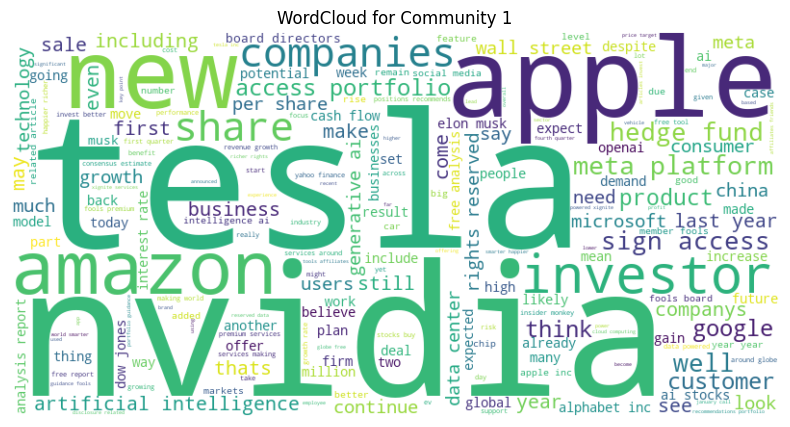

Community 2, Size: 1932


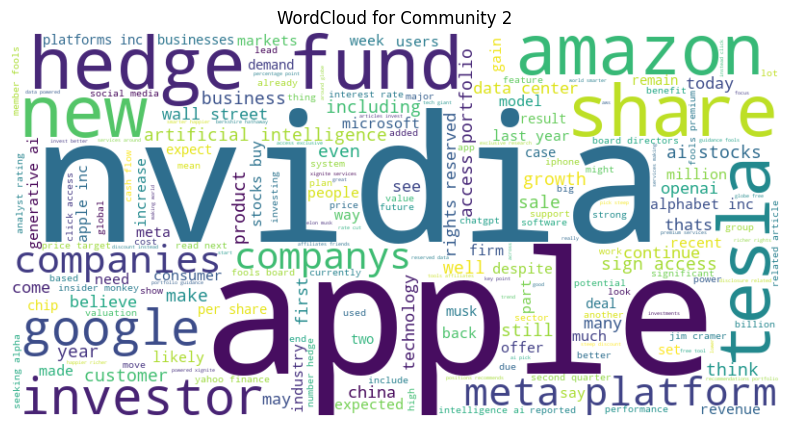

Community 3, Size: 808


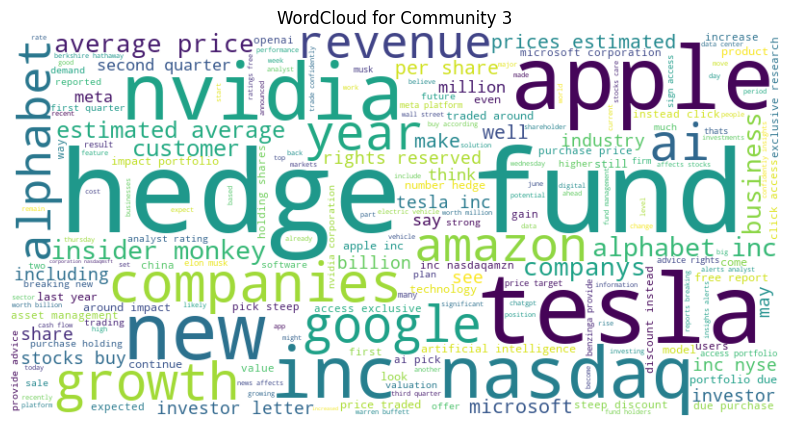

Community 4, Size: 576


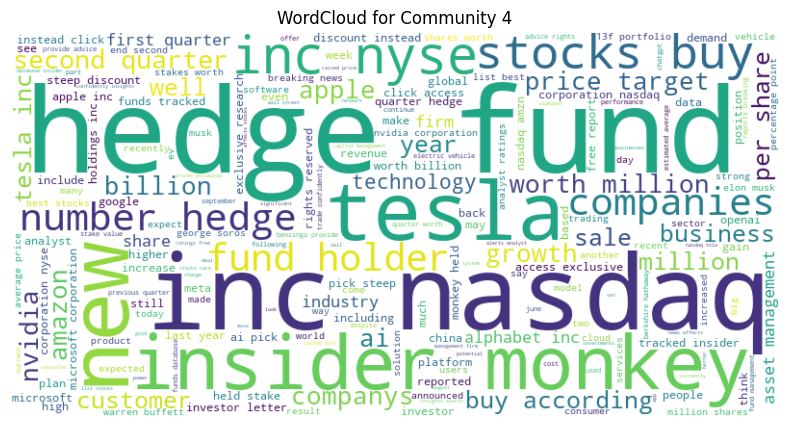

Community 5, Size: 515


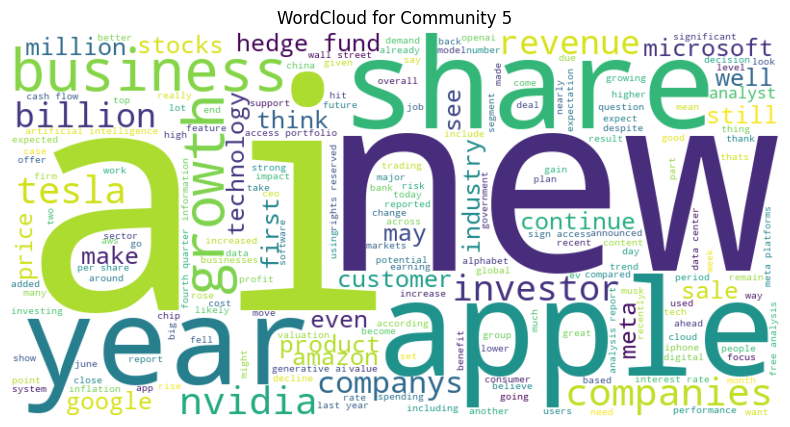

Community 6, Size: 481


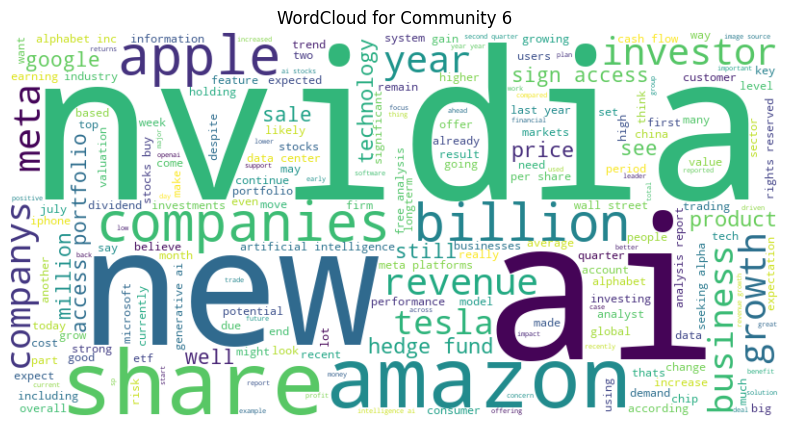

Community 7, Size: 386


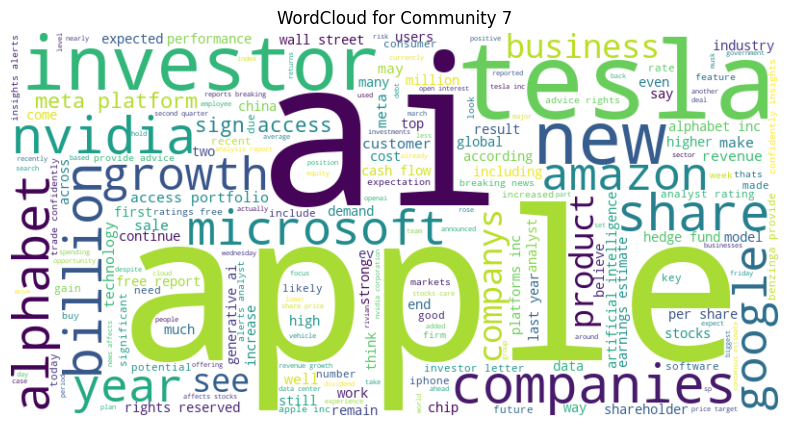

Community 8, Size: 379


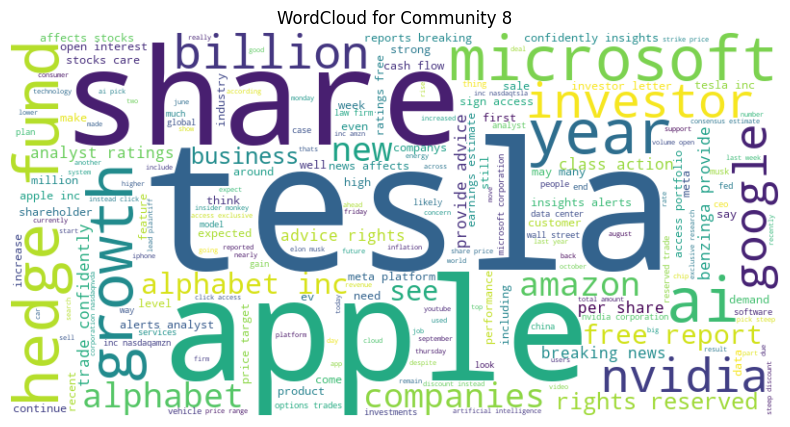

Community 9, Size: 351


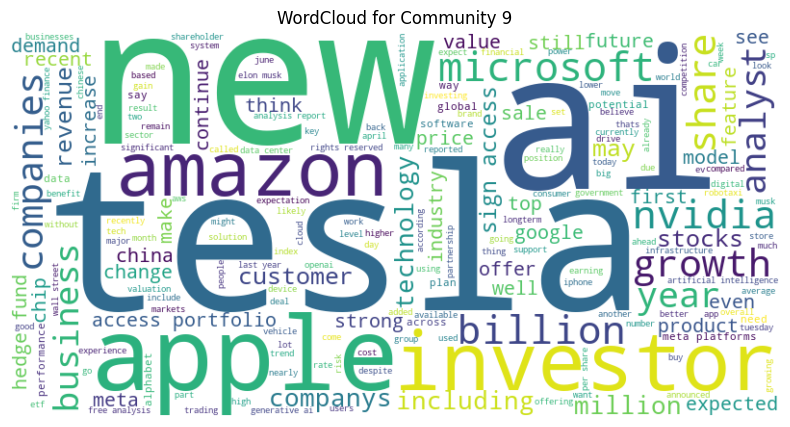

Community 10, Size: 333


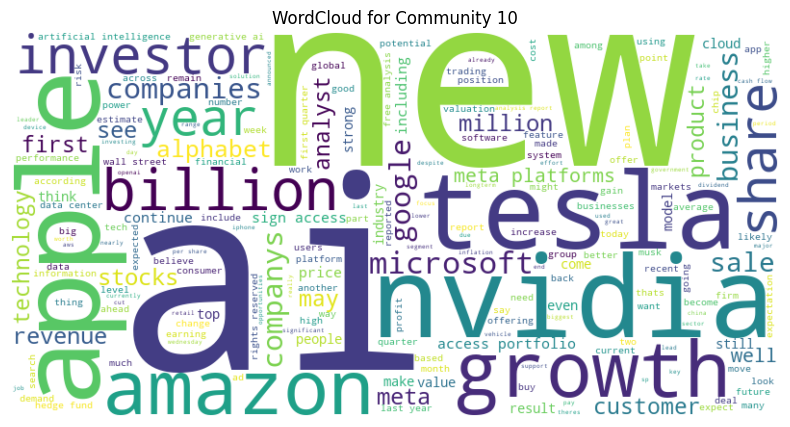

Community 11, Size: 332


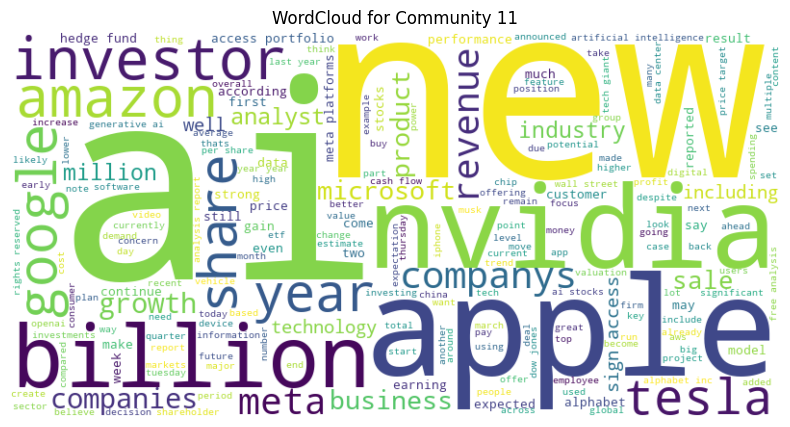

Community 12, Size: 295


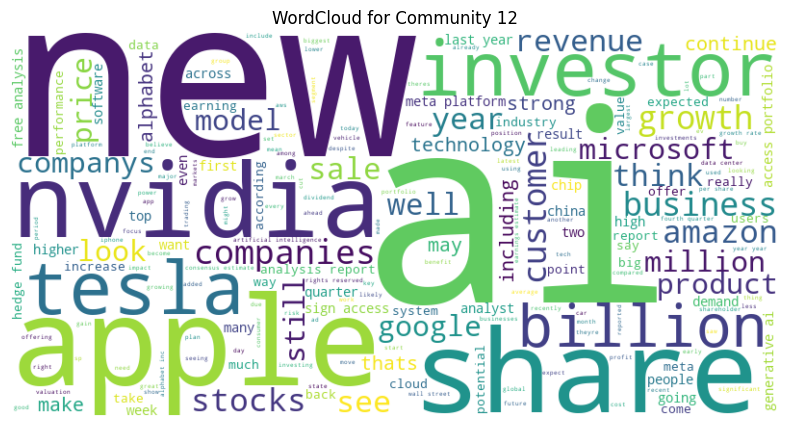

Community 13, Size: 286


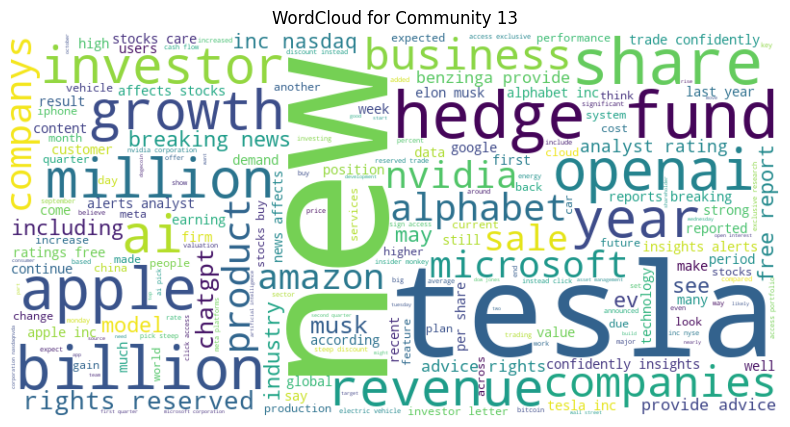

Community 14, Size: 273


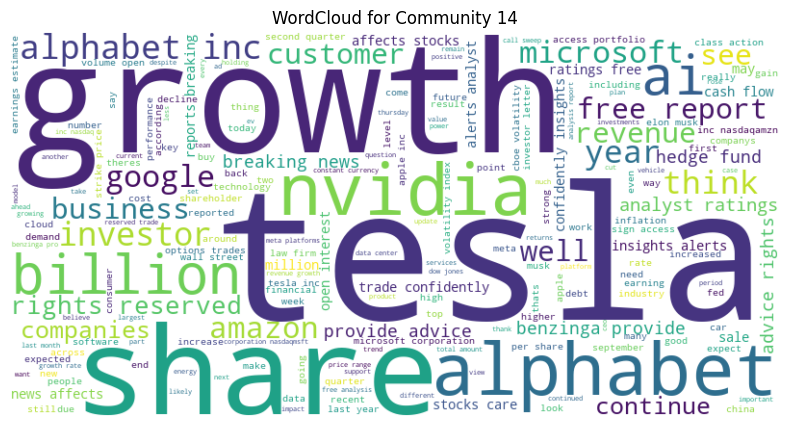

Community 15, Size: 271


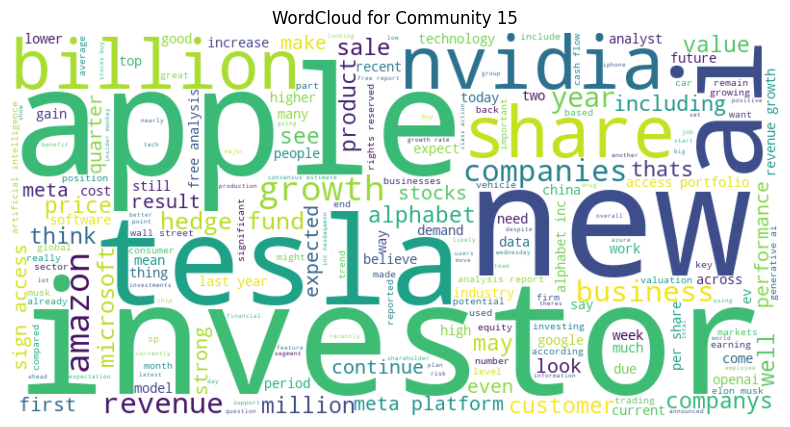

Community 16, Size: 258


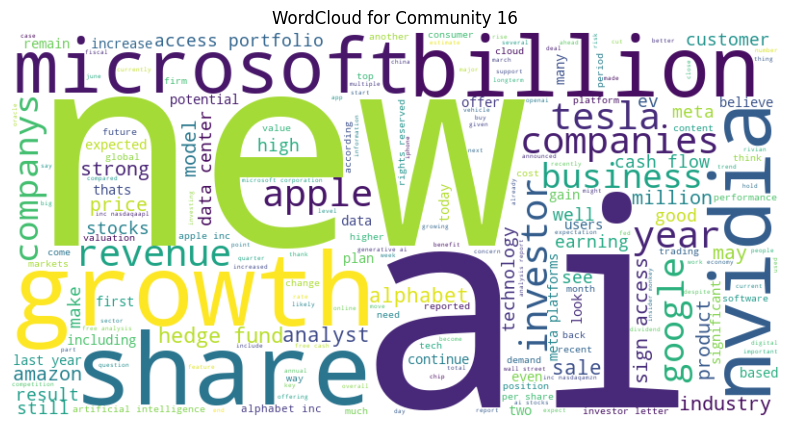

Community 17, Size: 240


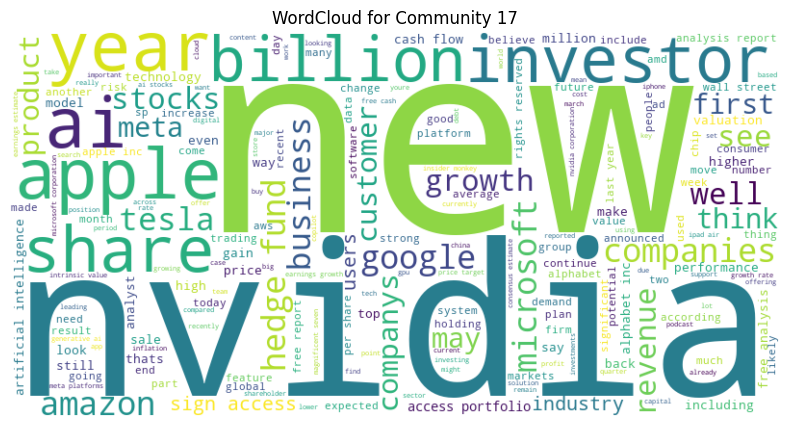

Community 18, Size: 224


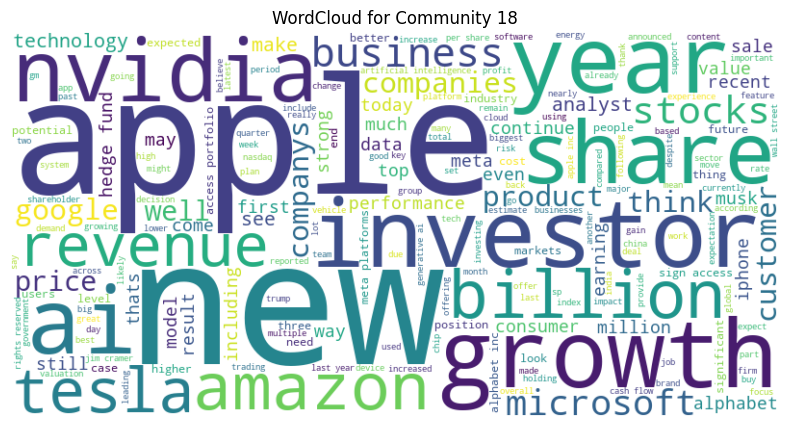

Community 19, Size: 199


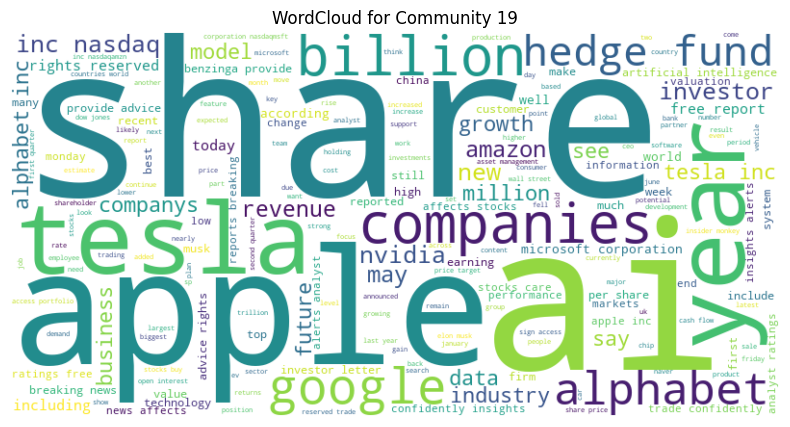

Community 20, Size: 174


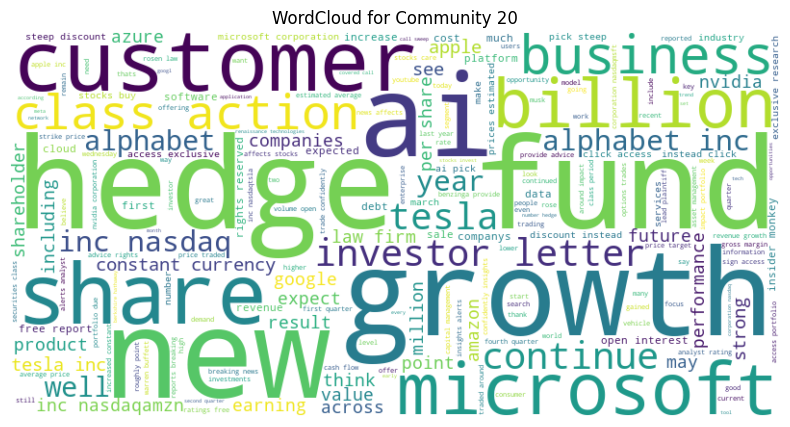

In [ ]:
from wordcloud import WordCloud

# Sort the communities by size
sorted_partition = sorted(partition, key=lambda x: len(x), reverse=True)

# Analyze the top 6 largest communities
for i in range(6):
    community = sorted_partition[i]
    print(f"Community {i+1}, Size: {len(community)}")

    # Combine the text of all documents in the community and preprocess
    texts = [news_df.iloc[node]['cleaned'] for node in community]
    
    # Create a frequency distribution of the words
    text_freq = " ".join(texts)

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_freq)

    # Display WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Community {i+1}")
    plt.show()

In [29]:
def average_gradient(df, stock, date_time, t):
    """
    Calculate the average gradient for a given stock around a specified date and time.
    
    Parameters:
    - df (DataFrame): The dataframe containing Date, stock prices as columns.
    - stock (str): The stock symbol for which to calculate the gradient (e.g., 'AAPL').
    - date_time (str or datetime): The reference date and time as a string or datetime object.
    - t (int): Number of timesteps before and after the date_time to calculate the gradient.
    
    Returns:
    - float: The average gradient (price change per timestep).
    """
    # Ensure date_time is in datetime format
    date_time = pd.to_datetime(date_time)

    #print("Important type check:", type(date_time), type(df['Date'][0]))
    
    # Determine indices for `t` steps before and `t` steps after, even if `date_time` is not in the data
    before_indices = df.index[df['Date'] <= date_time].to_numpy()[-(t[0]+1):]  # Last `t` steps before or equal
    after_indices = df.index[df['Date'] > date_time].to_numpy()[:t[1]]      # First `t` steps after

    if len(before_indices) < t[0]+1 or len(after_indices) < t[1]:
        return None, None
    
    #print(after_indices, before_indices)
    after_indices = np.sort(np.append(after_indices, before_indices[-1]))
    #print(after_indices)

    before_prices = df.loc[before_indices, stock].to_numpy()
    avg_gradient_before = np.gradient(before_prices).mean()

    after_prices = df.loc[after_indices, stock]
    avg_gradient_after = np.gradient(after_prices).mean()

    return avg_gradient_before, avg_gradient_after

def get_stock_gradient_change(stock_df, df_series, t=(2, 2)):
    # Get the stock symbol and date from the reddit data
    #if df_series['stock'] not in stock_dict:
    #    return None
    print(df_series.head())
    stock_input = df_series['stock']
    print(stock_input)

    if stock_input in stock_dict.values():
        stock = stock_input  # It's already a stock symbol
    elif stock_input in stock_dict:
        stock = stock_dict[stock_input]  # Convert company name to stock symbol
    else:
        return None  # Not a valid stock symbol or company name


    date_time = df_series['timestamp']

    average_gradient_before, average_gradient_after = average_gradient(stock_df, stock, date_time, t)

    if average_gradient_before is None or average_gradient_after is None:
        return None

    return average_gradient_after - average_gradient_before

def populate_reddit_df_with_stock_gradient_change(stock_df, news_df):
    news_df['stock_gradient_change'] = news_df.apply(lambda row: get_stock_gradient_change(stock_df, row), axis=1)
    


In [32]:
'''
    Important: The following code requires stock_df with a 'Date' column in datetime format.
'''
stock_df['Date'] = pd.to_datetime(stock_df['Date']) # Ensure the date is in datetime format

'''
    Example
'''
print("Number of communities:", len(partition))

example_community = list(partition[0])
print("Size of the first community:", len(example_community))

example = reddit.df.iloc[news_df.iloc[example_community[0]]]
print("Information for the first node in the first community:")
print(type(example))
print(example)
print("(end)")

# Calculate the average gradient change for the stock around the time of the first node
stock_change = get_stock_gradient_change(stock_df, example)

print("Stock change for the first node in the first community:", stock_change)


Number of communities: 1613
Size of the first community: 2


ValueError: setting an array element with a sequence.

In [ ]:
populate_reddit_df_with_stock_gradient_change(stock_df, reddit.df)

example = reddit.df.iloc[example_community[0]]

print(example['stock_gradient_change'])